# Conditions of Language Dynamics, week 5
# Syntactic constraints lab 

This simulation features a replication of
Culbertson & Smolensky (2012)'s model of learning biases for Greenberg’s Universal 18.

|       | N-Adj | Adj-N |
|---------|-------|-------|
|**Num-N**|  17%  | 27%   |
|**N-Num**|  52%  | 4%    |

The learning biases were previously experimentally unocvered in Culbertson, Smolensky & Legendre (2012). In this paper, the authors tested three hypotheses:

1. Learning involves tracking input statistics
2. Learners regularise variation
3. Learners regularise but only order that are easier to learn

The model in Culbertson & Smolensky (2012) reformulates these hypotheses in terms of Bayesian inference (which takes into account prior biases as well as the input likelihood) to find the best fit for the experimental data:

1. Input likelihood given a flat/uninformative prior (no bias)
2. Input likelihood given a regularisation prior (regularisation bias)
3. Input likelihood given a regularisation prior and a harmonic prior (regularisation and harmony biases)



## Overview

The model uses Bayesian inference to predict the types of grammars learners will infer given (1) a set of counts of [Adj-N, N-Adj, Num-N, N-Num] utterances and (2) their prior expectations in terms of variation and ordering combinations. 

The first part of code imports what we’ll need to use the binomial and beta distributions, to do logs and exponentials, and to generate random numbers of various kinds.


In [17]:
import random
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')

from scipy.stats import beta, binom
from math import log, exp
from scipy.special import logsumexp
from numpy.random import choice, binomial

## The input data

The input consists of counts of [Adj-N, N-Adj, Num-N, N-Num] with 40 total per modifier type. Whether the input is skewed toward pre- or post-nominal modifiers for each phrase type depends on the condition, as shown in the table.


|condition   | training counts|
|------------|---------------|
|1 | [28,12,28,12] |
|2 | [12,28,12,28] |
|3 | [12,28,28,12] |
|4 | [28,12,12,28] |

We’ll use a grid of probabilities to describe the space of possible generating grammars (i.e. hypotheses). We’ll need to use the grid twice–once for the probability of Adj-N (vs N-Adj), and again for the probability of Num-N (vs. N-Num).

In [18]:
#Training data is a list of lists of counts for each condition
#                     pattern 1        pattern 2          pattern 3        pattern 4
#                  (Adj-N,Num-N)     (N-Adj,N-Num)     (N-Adj,Num-N)     (Adj-N,N-Num)
training_data = [[28, 12, 28, 12], [12, 28, 12, 28], [12, 28, 28, 12], [28, 12, 12, 28]]

grid_granularity = 100 
possible_p = []
for i in range(1, grid_granularity):
    possible_p.append(i / (grid_granularity + 0.))

*Check out `training_data`. How would you access just the counts for condition 2? Also take a look at the grid. What would a hypothesis of 0.99 mean?*

## Likelihood

The likelihood here is calculated using the binomial distribution. We are interested in the likelihhod of the individual's inferred grammar (i.e., NP ordering rules) given the proportion of Adj-N in Adj trials, and the proportion of Num-N out in Num trials.

The function below calculates log likelihood of data, (where data are counts representing number of Adj-N out of total Adj instances and number of Num-N out of total Num instances) given point probability of Adj-N, and Num-N.

In [19]:
def U18_likelihood(data, p_AdjN, p_NumN):
    loglikelihood = []
    loglikelihood_AdjN = binom.logpmf(data[0], data[0] + data[1], p_AdjN)
    loglikelihood_NumN = binom.logpmf(data[2], data[2] + data[3], p_NumN)
    loglikelihood = loglikelihood_AdjN + loglikelihood_NumN #summing logs = multiplying non-log
    return loglikelihood   

*Check out U18_likelihood function. It returns log probabilities. Find the line of code in the function that would allow you to calculate the likelihood of getting 28 Adj-N counts out of a total of 40 when the underlying probability of Adj-N according to the grammar is 0.7 (versus 0.3 of N-Adj). Calculate it!*

## Prior

The prior in this model has two parts. One part is regularization as encoded by the parameters of the beta distribution. The two parameters of the beta distribution are (annoyingly) called alpha and beta. Here we want two separate asymmetrical beta distributions–favoring either probabilities close to one or close to zero, but not both (see figures a and b below). 

The second part of the prior is harmony. This is the part pf the prior which favors particular combinations of orders (i.e., Adj-N with Num-N); in order to get it we need to promote or penalize particular parts of the two dimensional grammar space. 

We can do this by defining four “components" using different combinations of alpha and beta, with alpha constrained to be higher than beta. The graph below shows beta distributions with (alpha=10, beta=10), (alpha=15, beta=3), (alpah=15, beta=0.1) for Adj-N, and the reverse for Num-N:

![alt text](http://ling.ed.ac.uk/~simon/simlang/fig2.jpg "grammar space")


![alt text](http://ling.ed.ac.uk/~simon/simlang/fig3.jpg "beta distributions")

Given these four components, we calculate the prior probability of any grammar. This will actually be the sum of its probability given the beta distributions governing p(Adj-N) and p(Num-N) for each component, weighted by the probability of that component. The latter is determined by gamma (g). If the probability of a given component (e.g., g[4], which corresponds to component 4) is low, then pattern 4 grammars very likely to be generated by it will have a low prior probability.

The function below calculates the log prior probability of a given p_AdjN and p_NumN given a set of parameters. This is a sum over the probabilities given by each mixture component. Parameters are: g (set of four mixture weights), a(lpha), b(eta) (Beta shape parameters).

In [20]:
def U18_prior(g, a, b, p_AdjN, p_NumN):
    pattern1_component = [a, b, a, b] # higher prob for Adj-N, Num-N
    pattern2_component = [b, a, b, a] # higher prob for N-Adj, N-Num
    pattern3_component = [b, a, a, b] # higher prob for N-Adj, Num-N
    pattern4_component = [a, b, b, a] # higher prob for Adj-N, N-Num
    components = [pattern1_component, pattern2_component, 
                  pattern3_component, pattern4_component]
    logprior = []
    for i in range(0,4): # loop over all four components
        logprior_i_Adj = beta.logpdf(p_AdjN, components[i][0], components[i][1])
        logprior_i_Num = beta.logpdf(p_NumN, components[i][2], components[i][3])
        logprior_i = logprior_i_Adj + logprior_i_Num
        logprior.append(logprior_i)
    # a+b+... in log space = log(exp(a)+exp(b)+...)
    logprior = log((g[0] * exp(logprior[0])) + 
                   (g[1] * exp(logprior[1])) + 
                   (g[2] * exp(logprior[2])) + 
                   (g[3] * exp(logprior[3])))
    return logprior

*Take a look at the four components in the prior. Can you see why they are defined by those combinations of alpha and beta?*

*Each component - a combination of two beta distributions - can in principle generate any grammar, that is any pair [p(Adj-N), p(Num-N)]. Which component assigns the highest probability to the pair [0.8,0.8]? How about [0.4,0.9]?*

### The optimal prior parameters

The parameters of the prior are alpha, beta, gamma. The first two (called a, and b in the code) encode the regularization bias. The higher a is relative to b, the more regularization. The third, g is a set of weights for the four components, summing to 1. We searched through these parameters to find the ones that fit our experimental data (shown in the plot below) best.

![alt text](http://ling.ed.ac.uk/~simon/simlang/fig4.jpg "experimental data")

The best fit parameters were:

In [21]:
#                  gamma                       alpha, beta
fit_parameters = [[0.6293, 0.3706, 0.0001, 0], 16.5,  0.001]

## Posterior

The posterior distribution over grammars can now be calculated using the likelihood and the prior with the fit parameters. This function calculates the log posterior probability of a set of counts for all possible p_AdjN, p_NumN combinations, given prior parameters g, a(lpha), b(eta).

In [22]:
def U18_posterior(g, a, b, data):
    posterior = [] 
    for p_a in range(len(possible_p)):
        for p_n in range(len(possible_p)):
            lik_i = U18_likelihood(data, possible_p[p_a], possible_p[p_n])
            prior_i = U18_prior(g, a, b, possible_p[p_a], possible_p[p_n]) 
            posterior.append(lik_i + prior_i)  
    return posterior

*Given the fit parameters, will the model predict a weak or strong regularization bias? Will a set of counts generated from a grammar like [0.8,0.2] (for [p(Adj-N), p(Num-N)])  have a high, medium or low posterior probability?*

## Plot the results

The model can now be used to generate predicted learning outcomes; given some input data, and the prior parameters, we can generate sampled grammars and plot them in the two-dimensional grammar space we’ve be using. The figure belows shows this as reported in the original Culbertson & Smolensky (2012) paper. 

![alt text](http://ling.ed.ac.uk/~simon/simlang/fig5.jpg "culbertson & smolensky results")

You can use the `U18_roulette_wheel` function to reproduce this. This function is similar to those you’ve previously used to sample probabilities. The difference is that this function samples pairs of p(Adj-N), p(Num-N) probabilities, and it lets you specify how many such samples you want. You’ll notice there’s also a normalization function `normalize_log_distribution` which takes log probabilities output by the posterior and makes them a proper (non-log) probability distribution for plotting.

In [23]:
def normalize_log_distribution(distribution):
    exp_dist = []
    for logp in distribution:
        exp_dist.append(exp(logp))
    norm_dist = []
    for p in exp_dist:
        norm_dist.append(p / sum(exp_dist))
    return norm_dist


def U18_roulette_wheel(g, a, b, data, num_samps):
    post = U18_posterior(g, a, b, data) # calculate posterior given training data and prior parameters
    post = normalize_log_distribution(post)
    # make a grid of all possible p_AdjN, p_NumN combinations at the granularity specified
    grid = []
    for p_a in range(len(possible_p)):
        for p_n in range(len(possible_p)):
            grid.append([possible_p[p_a], possible_p[p_n]])
    # samples some grammars!
    grammars = []
    for i in range(num_samps):
        r = choice(a=range(len(grid)), p=post)   # choose an index from the grid according to it's posterior probability  
        grammars.append(grid[r])
    return grammars

Now we have a function to plot the results as a scatter plot.

In [24]:
def plot_grammars(g_1, g_2, g_3, g_4):
    
    plt.figure(figsize=(6, 6))
    for g in g_1:
        plt.scatter([g[0]], [g[1]], color='red', alpha=0.5)

    for g in g_2:
        plt.scatter([g[0]], [g[1]], color='blue', alpha=0.5)

    for g in g_3:
        plt.scatter([g[0]], [g[1]], color='orange', alpha=0.5)

    for g in g_4:
        plt.scatter([g[0]], [g[1]], color='purple', alpha=0.5)

    plt.xlabel("P(Adj-N)")
    plt.ylabel("P(Num-N)")
    plt.xlim(0, 1)
    plt.ylim(0, 1)
    plt.grid()

## Questions

1. Generate samples `g_1, g_2, g_3, g_4` using function calls like:
```python
g_1 = U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[0], 100)
```
Then call the plotting function to plot them. Does your plot look like figure above from the paper? (N.B. This might take a while to run.)

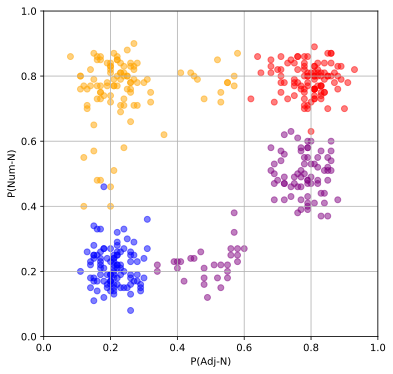

In [25]:
g_1 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[0], 100)
g_2 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[1], 100)
g_3 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[2], 100)
g_4 =  U18_roulette_wheel(fit_parameters[0], fit_parameters[1], fit_parameters[2], training_data[3], 100)
plot_grammars(g_1, g_2, g_3, g_4)

2. What does it mean that the highest value of g is for component 1? Why do you think that might be the highest given the population of learners tested in the experiment? Come up with a new set of g values that you think would more accurately reflect the typology (e.g., in table at the start of the notebook) and redo the samples and plot. Did it turn out as you expected?

3. What do you think would happen if the regularization bias were not as strong? Change the a,b parameters and see if you were right.